# Recommendations with IBM

In this notebook, you will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 


You may either submit your notebook through the workspace here, or you may work from your local machine and submit through the next page.  Either way assure that your code passes the project [RUBRIC](https://review.udacity.com/#!/rubrics/2322/view).  **Please save regularly.**

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

At the end of the notebook, you will find directions for how to submit your work.  Let's get started by importing the necessary libraries and reading in the data.

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
from difflib import SequenceMatcher

In [122]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

#### Load user-item interactions file

In [60]:
df_interaction = pd.read_csv('data/user-item-interactions.csv')
df_interaction.drop('Unnamed: 0', axis=1, inplace=True)
df_interaction.head()

,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier...",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


#### Check number of unique users

In [62]:
df_interaction.email.unique().shape[0]

5149

#### There are missing emails

In [63]:
df_interaction[df_interaction.email.isnull()]

,article_id,title,email
25131,1016.0,why you should master r (even if it might even...,NaN
29758,1393.0,the nurse assignment problem,NaN
29759,20.0,working interactively with rstudio and noteboo...,NaN
29760,1174.0,breast cancer wisconsin (diagnostic) data set,NaN
29761,62.0,data visualization: the importance of excludin...,NaN
35264,224.0,"using apply, sapply, lapply in r",NaN
35276,961.0,beyond parallelize and collect,NaN
35277,268.0,sector correlations shiny app,NaN
35278,268.0,sector correlations shiny app,NaN
35279,268.0,sector correlations shiny app,NaN


#### Load contents file

In [12]:
df_content = pd.read_csv('data/articles_community.csv')
df_content.drop('Unnamed: 0', axis=1, inplace=True)
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

#### There are 5148 unique users with valid emails and 17 null emails that are grouped as a single email.

In [64]:
total_email_entries = df_interaction.email.unique().shape[0] 
null_email_entries = df_interaction[df_interaction.email.isnull()].shape[0]
print('Total email entries: ', total_email_entries)
print('Null email entries: ', null_email_entries)
print('Valid users: ', total_email_entries - 1)

Total email entries:  5149
Null email entries:  17
Valid users:  5148


#### We drop entries with null emails

In [65]:
df_interaction_clean = df_interaction.dropna()

#### An user interacts in average with 16 articles. 50% of users interact with 5 articles. Outliers interacted with as many as 364 articles. 

In [66]:
df_ = df_interaction_clean.groupby('email').agg({'article_id':'size'})\
.rename(columns={'article_id':'number_articles'})
df_.describe()

,number_articles
count,5148.000000
mean,8.930847
std,16.802267
min,1.000000
25%,1.000000
50%,3.000000
75%,9.000000
max,364.000000


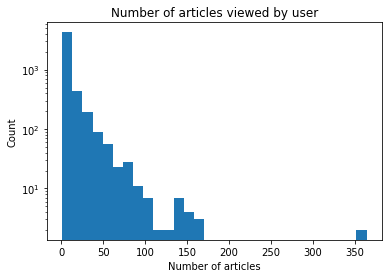

In [67]:
plt.hist(df_.number_articles, bins=30, log=True)
plt.xlabel('Number of articles')
plt.ylabel('Count')
plt.title('Number of articles viewed by user');
#df_.number_articles.hist(bins=30, log=True)

In [79]:
# Fill in the median and maximum number of user_article interactios below

median_val = df_.median()[0] # 50% of individuals interact with _ number of articles or fewer.
max_views_by_user = df_.max()[0] # The maximum number of user-article interactions by any 1 user is _.
median_val, max_views_by_user

(3.0, 364)

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

#### No obvious duplicates. Shape is the same after drop_duplicates

In [174]:
df_content.shape, df_content.drop_duplicates().shape

((1056, 5), (1056, 5))

#### There are article_id duplicates

In [175]:
df_content.drop_duplicates(subset=['article_id']).shape

(1051, 5)

#### All were dropped except for the first occurrence

In [176]:
df_content.drop_duplicates(subset=['article_id'], inplace=True)

#### I can also see that articles 1 and 4 are close

In [168]:
df_content.head()

,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


#### They are 40% similar. Is that sufficient to consider them duplicates? I consider not.

In [165]:
SequenceMatcher(None, df_content.doc_body[0], df_content.doc_body[4]).ratio()

0.39732239257179874

#### Are there any highly-similar pairs?

In [167]:
#combinations = list(itertools.combinations(df_content.index, 2))
#match_dict = {comb: SequenceMatcher(None, df_content.doc_body[comb[0]], df_content.doc_body[comb[1]]) for comb in combinations}